In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
torch.manual_seed(0)
from torch import nn
import torch.nn.functional as F
import torchzero as tz
from visualbench import FunctionDescent, test_functions

# 4. Second order methods

### 4.1 Overview

If first order methods make use of the gradient of the objective function $\nabla f(x_t)$, second order methods also use second order information, i.e. the hessian matrix $H_t$, which tells us about the curvature of the function and allows the optimization method to converge much quicker on a class of functions.

The hessian matrix can be computed via autograd, or it can be estimated using just gradients, which is what quasi-newton methods do (see [5. Quasi-Newton methods](../5.%20Quasi-Newton%20methods)). In this notebook we will review the "true" second order methods that use exact hessian information via autograd.

There are two main classes of second order methods, ones that explicitly use the hessian matrix, thus requiring $N^2$ memory, and matrix-free methods that are suitable for very large scale optimization.

In torchzero, since we rely on PyTorch autograd, Newton's method appears to be efficient under ~1000 variables. It will also depend largely on how well PyTorch can vectorize the hessian-vector products for a particular function.

Matrix-free Newton uses about $4N$ memory because only needs to store a few variables. It is well suited for very large scale convex problems (e.g. 100,000,000 variables), however for non-convex or very badly scaled problems single step my be slow to compute and require many hessian-vector products. Modifications suitable for non-convex problems exist too.

#### 4.1.1 Newton's method

**Newton's method**, also known as Newton–Raphson method, is a root-finding method used to find solutions to equation $f(x)=0$.

In order to use Newton's method to minimize a function, we can use it to find solutions to $f'(x)=0$, i.e. the critical points (points where gradient is zero). As long as $f$ is twice-differentiable, any solution to $f'(x)=0$ is either minimum, maximum or a saddle point. Therefore if the function has maximums or saddle points, one needs to be careful as standard Newton's method may converge to them instead of the desired minimum.


When applied to minimizing a function, the Newton iteration is:
$$
x_{t+1} \leftarrow x_t - H(x_t)^{-1}\nabla f(x_t)
$$

So on each step inverse hessian times gradient is subtracted from parameters.

In practice the Newton step is computed as a solution to a linear system because that is faster to compute:
$$
\text{solve:}\\\\ H(x_t)v_t = \nabla f(x_t)
$$
$$
x_{t+1} \leftarrow x_t - v_t
$$

Another interpretation of the Newton's method is that it constructs and minimizes a quadratic approximation of the objective function. Therefore if the objective function is quadratic, the approximation will be perfect and Newton's method converges in a single step with step size of 1.

As an example, consider the following hessian for a function of two variables $x_1$ and $x_2$:
$$
\begin{bmatrix}
10 & 8\\
8 & 10
\end{bmatrix}
$$

Values of this matrix are double the coefficients of the quadratic model. That is because derivative of $x^2$ is $2x$, so the function with that derivative the coefficients are divided by two. So the quadratic model given by hessian above is:
$$
f(x_1, x_2) = (10x_1x_1 + 8x_1x_2 + 8x_2x_1 + 10x_2x_2) / 2
$$
Which is:
$$
f(x_1, x_2) = 5x_1^2 + 5x_2^2 + 8x_1x_2
$$

Now suppose the gradient $\nabla f(x_t)$ is $\frac{df}{dx_1}=6, \frac{df}{dx_2}=-4$, so it is $[6, -4]$, the model becomes:
$$
f(x_1, x_2) = \underbrace{5x_1^2 + 5x_2^2 + 8x_1x_2}_{\frac{1}{2}\mathbf{x}^T H \mathbf{x}} + \underbrace{6x_1 - 4x_2}_{\mathbf{g}^T \mathbf{x}}
$$

Or in a more general form, given gradient $g$ and hessian $H$, the model is:
$$
f_{\mathbb{quad}}(v) = \frac{1}{2}v^T H v + g^T v
$$

The model is centered around 0, so $f_{\mathbb{quad}}(v)$ corrensponds to $f(x_t + v)$

A Newton step with a step size of 1 minimizes this quadratic model of the objective function.

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(12,6))

# GD
func = FunctionDescent('ill1')
optimizer = tz.Optimizer(func.parameters(), tz.m.LR(1e-1))
func.run(optimizer, max_steps=500)
func.plot(log_contour=True, ax=ax[0])
ax[0].set_title("GD (500 steps)")

# Newton
func = FunctionDescent('ill1')
optimizer = tz.Optimizer(func.parameters(), tz.m.Newton(), tz.m.LR(1))
func.run(optimizer, max_steps=100)
func.plot(log_contour=True, ax=ax[1])
ax[1].set_title("Newton (1 step)")

plt.show()

finished in 0.4s., reached loss = 0.000146                                      
finished in 0.3s., reached loss = 0                                      


#### 4.1.2 Dampened Newton
**Dampened Newton** is simply Newton's method with a step size that is allowed to be smaller than 1, for example it can be selected via a [line search](<../8. Line search>).

$$
x_{t+1} \leftarrow x_t - \eta H(x_t)^{-1}\nabla f(x_t)
$$

where $\eta$ is the step size.

This is often a better choice as Newton can be very unstable on some functions, especially non-convex ones.

finished in 0.1s., reached loss = 0                                      


<Axes: >

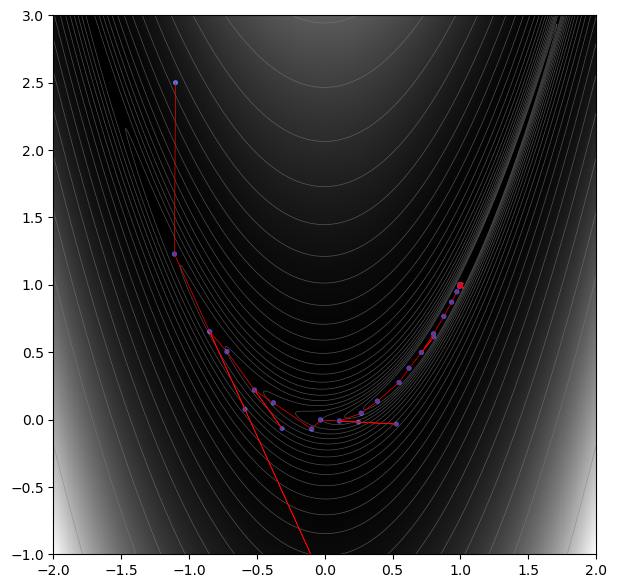

In [ ]:
func = FunctionDescent('rosen')
optimizer = tz.Optimizer(
    func.parameters(),
    tz.m.Newton(),
    tz.m.Backtracking()
)
func.run(optimizer, max_steps=25)
func.plot(log_contour=True)

#### 4.1.3 Newton with trust region
Newton can also be used with [trust regions](<../9. Trust region>) as an alternative to line searches. Some trust regions can also prevent it from being stuck on saddle points and maximums.

finished in 0.1s., reached loss = 0                                      


<Axes: >

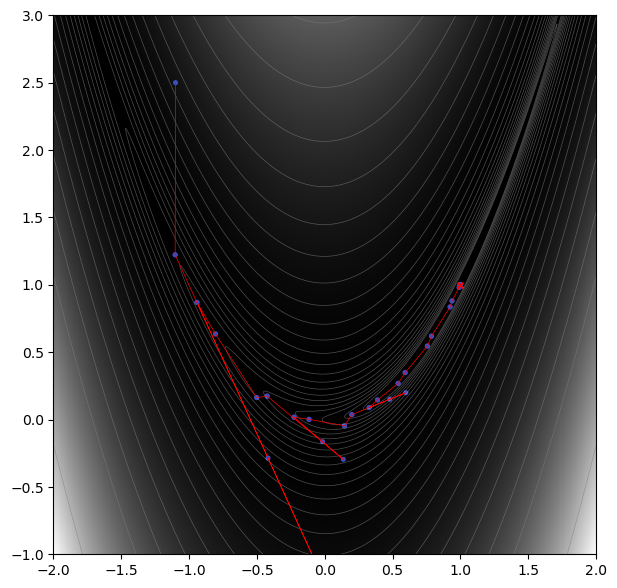

In [ ]:
func = FunctionDescent('rosen')
optimizer = tz.Optimizer(
    func.parameters(),
    tz.m.LevenbergMarquardt(tz.m.Newton()),
)
func.run(optimizer, max_steps=25)
func.plot(log_contour=True)

#### 4.1.4 Newton for non-convex functions

As mentioned before, Newton may converge to a maximum or a saddle point instead of a minimum.

A simple modification to avoid converging to saddle points involves adding an identity matrix multiplied by scalar $m$ to the hessian before computing the Newton step. 
$$
x_{t+1} \leftarrow x_t - (H(x_t) + mI)^{-1}\nabla f(x_t)
$$
The scalar $m$ should be selected such that after adding scaled identity matrix to the hessian, all eigenvalues of the hessian become positive. Larger scalars will bring Newton step closer to a gradient descent step, thus some convergence speed may be lost. It may be hard to pick a good scalar without computing the eigendecomposition of the hessian. And if you are willing to compute the eigendecomposition, might as well use the second modification detailed below as it tends to converge much faster.

The second modification of Newton's method to avoid converging to maxima involves modifying the eigenvalues of the hessian in some way to be positive. For example one might take absolute value of the eigenvalues or set all negative eigenvalues to some fixed positive number. A similar modification involves a modified cholesky decomposition which should be cheaper than eigendecomposition, but it isn't implemented in torchzero. Fortunately eigendecomposition is still reasonably cheap compared to cost of computing the hessian in Pytorch, plus it is re-used to invert the hessian.

In torchzero we can pass an eigenvalue transformation into the `eigval_fn` argument, for example ``lambda x: x.abs().clip(min=1e-6)``, or ``lambda x: torch.where(x<1e-8, 1, x)``.


To demonstrate, we will run Newton on the following non-convex function with a saddle point:
$$
f(x,y) = (x-6)^2 + (y - 0.2)^2 + (x * y - 2)^2
$$

We will run Newton fix a small normalized step size to show the trajectory each modification takes, while noting that with a backtracking line search standard Newton also fails to minimize this function.

finished in 2.8s., reached loss = 42.034                                      
finished in 1.3s., reached loss = 0.0177                                      
finished in 0.6s., reached loss = 0.0175                                      


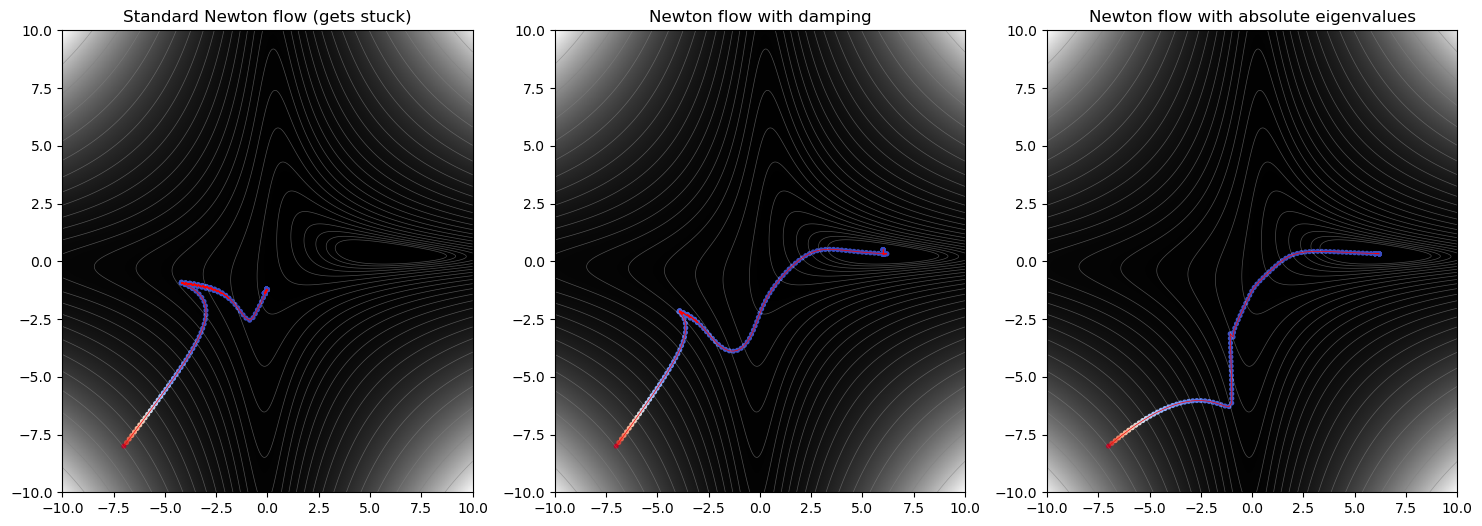

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(18,6))
ax = np.ravel(ax)

# --------------------------------- standard --------------------------------- #
func = FunctionDescent('star')
optimizer = tz.Optimizer(
    func.parameters(),
    tz.m.Newton(),
    tz.m.Normalize(2e-1)
)
func.run(optimizer, max_steps=1000)
func.plot(log_contour=True, ax=ax[0])
ax[0].set_title("Standard Newton flow (gets stuck)")

func = FunctionDescent('star')
optimizer = tz.Optimizer(
    func.parameters(),
    tz.m.Newton(damping=10),
    tz.m.Normalize(2e-1)
)
func.run(optimizer, max_steps=500)
func.plot(log_contour=True, ax=ax[1])
ax[1].set_title("Newton flow with damping")

# ------------------------------ absolute value ------------------------------ #
func = FunctionDescent('star')
optimizer = tz.Optimizer(
    func.parameters(),
    tz.m.Newton(eigval_fn=lambda x: x.abs().clip(min=1e-8)),
    tz.m.Normalize(2e-1)
)
func.run(optimizer, max_steps=250)
func.plot(log_contour=True, ax=ax[2])
ax[2].set_title("Newton flow with absolute eigenvalues")

plt.show()

#### 4.1.5 Improved Newton's method

A modification of Newton's method uses an approximated rational approximation model instead of a quadratic model, which reflects more curvature information. Screenshot from the paper:

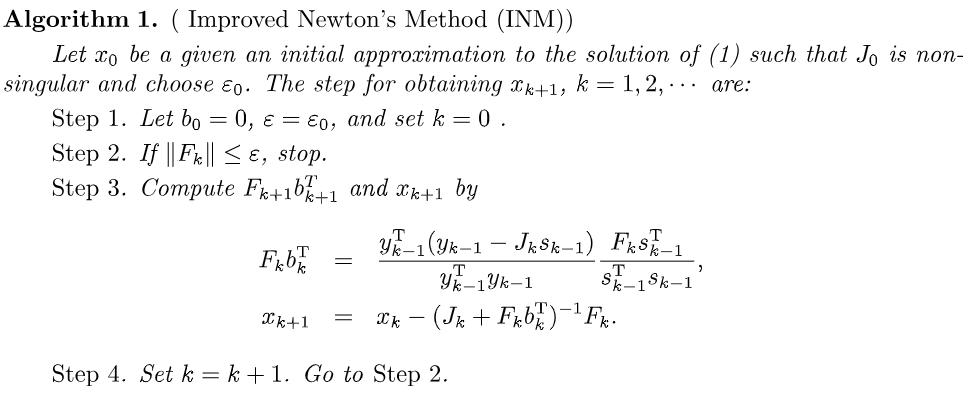

Here $s_k=x_k - x_{k-1}$ and $y_k = \nabla f(x_k) - \nabla f(x_{k-1})$. Note that this method is described for root-finding problems; for optimization we replace values vector $F_k$ with gradient $\nabla f(x_k)$ and jacobian $J_k$ with hessian $H(x_k)$.

There is almost no extra computational overhead compared to Newton, and it is faster than Newton on logistic regression.

Reference: *[Saheya, B., et al. "A new Newton-like method for solving nonlinear equations." SpringerPlus 5.1 (2016): 1269.](https://d-nb.info/1112813721/34)*

finished in 0.1s., reached loss = 1.42e-12                                      


<Axes: >

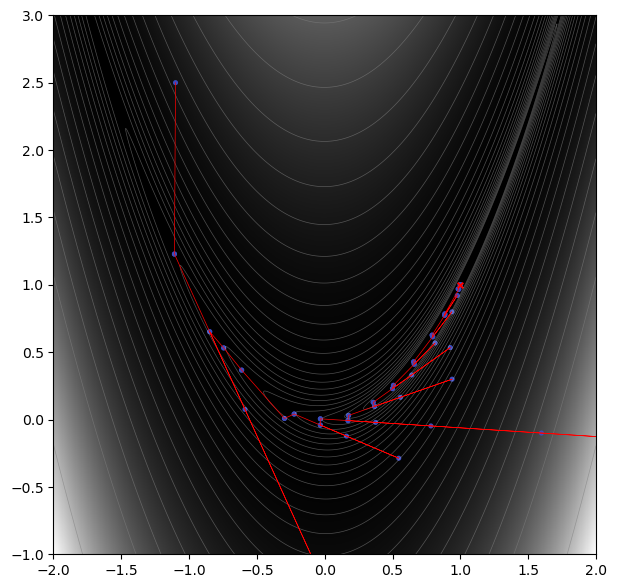

In [ ]:
func = FunctionDescent('rosen')
optimizer = tz.Optimizer(
    func.parameters(),
    tz.m.ImprovedNewton(),
    tz.m.Backtracking(),
)
func.run(optimizer, max_steps=25)
func.plot(log_contour=True)

### 4.2 Speeding up
Newton's has two big disadvantages:
- it requires at least $N^2$ memory to store the hessian.
- it requires to solve an $n \times n$ linear system on each step.

There are methods to make Newton's method a little bit faster or significantly faster to compute, and there are ways to make it use significantly less memory.

#### 4.2.1 Update frequency

A simple but effective way to speed Newton up is to compute the hessian every $n>1$ steps rather than every step, for example every 10 or every 100 steps, assuming the hessian doesn't change by too much during those steps. In this case it may be more efficient to also compute hessian inverse $H^{-1}$ and then reuse it until next hessian computation, this saves us from having to solve many linear systems.

On large scale problems, despite requiring more steps to converge, this can take significantly less time due to computing less hessians.

In some cases it may even be possible to compute the hessian once at the beginning and then reuse it, for root-finding this method is called the **Chord method**.

finished in 2.7s., reached loss = 1.42e-14                                      


<Axes: >

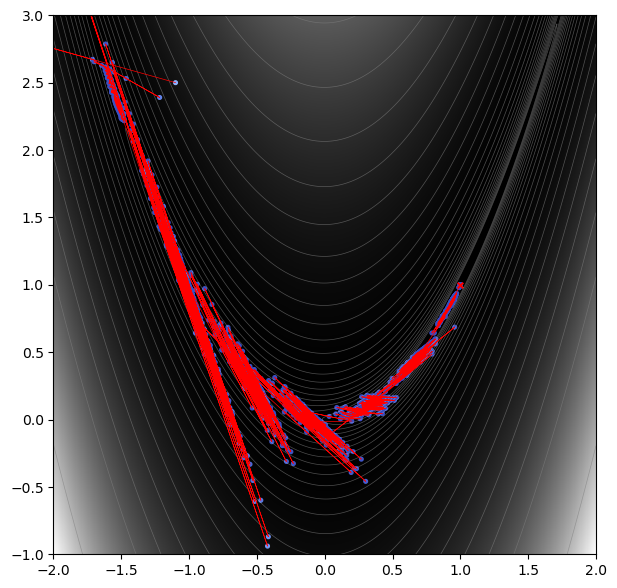

In [16]:
func = FunctionDescent('rosen')
optimizer = tz.Optimizer(
    func.parameters(),
    tz.m.Chord(update_freq=100, eigval_fn=lambda x: x.abs()),
    tz.m.Backtracking(),
)
func.run(optimizer, max_steps=1000)
func.plot(log_contour=True)

#### 4.2.2 Inverse-free Newton
It is possible to skip solving the $H(x_t)v_t = \nabla f(x_t)$ linear system and instead estimate $H^{-1}$ in a recurrent fashion, for example using following formula, where $Y_{t}$ approximates $H_t^{-1}$:
$$
Y_{t} = Y_{t-1}(2I - H_t Y_{t-1})
$$
$$
x_{t+1} = {x_t} - Y_t \nabla f(x_t)
$$

In pytorch in most cases computing the hessian uses far more time that solving the linear system, therefore the time gains from using inverse-free method is small. It is far more useful when expression for hessian (or jacobian in root-finding case) can be computed efficiently. Nontheless it is included in torchzero for completeness.

Reference: *[Massalski, Marcin, and Magdalena Nockowska-Rosiak. "INVERSE-FREE NEWTON'S METHOD." Journal of Applied Analysis & Computation 15.4 (2025): 2238-2257.](https://www.jaac-online.com/article/doi/10.11948/20240428)*

finished in 0.1s., reached loss = 0.000658                                      


<Axes: >

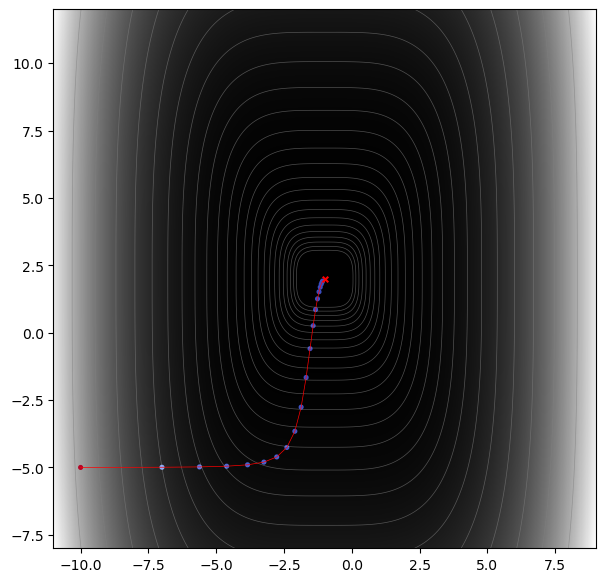

In [ ]:
func = FunctionDescent('convex43')
optimizer = tz.Optimizer(
    func.parameters(),
    tz.m.InverseFreeNewton()
)
func.run(optimizer, max_steps=20)
func.plot(log_contour=True)

#### 4.2.3 Subspace Newton
Subspace Newton is a version of Newton's method which computes Newton's step in a smaller subspace. For example, 100-dimensional subspace means hessian is a $100 \times 100$ matrix which is easy to store and solve the linear system, regardless of dimensionality of the problem. By computing Newton's step in a subspace, we restrict it to only be able to move within that subspace, so it doesn't converge as quickly, but with appropriate choice of subspace it can still be very fast.

Mathematically, instead of computing full Newton's step as solution to $H_t v_t = \nabla f(x_t)$, it computes a smaller **sketched** $s \times s$ hessian matrix $S_t^T H_t S_t$, where $S_t$ is a $n \times s$ sketching matrix, $n$ is number of variables and $s$ is sketch size, and solves $(S_t^T H_t S_t) S^T v_t = S^T \nabla f(x_t)$.

$S_t^T H_t S_t$ can be computed in $s$ backpropagation passes or even faster by using batched hessian-vector products available in pytorch.

The sketching matrix $S_t$ can be anything, for example a random matrix, but ideally it should be an orthonormal matrix. Orthonormality is also necessary when using trust region methods. Random subspace Newton[1] uses a random orthonormal matrix; method of common directions[2] uses an orthonormalized matrix made of past gradient directions.

References:
1. *[Gower, Robert, et al. "RSN: randomized subspace Newton." Advances in Neural Information Processing Systems 32 (2019).](https://arxiv.org/abs/1905.10874)*
2. *Wang, Po-Wei, Ching-pei Lee, and Chih-Jen Lin. "The common-directions method for regularized empirical risk minimization." Journal of Machine Learning Research 20.58 (2019): 1-49.*

Using the method of common directions we are able to solve a large 1,000,000-dimensional quartic problem.

In [3]:
DIM = 1_000_000
device = 'cuda' if torch.cuda.is_available() else None
generator = torch.Generator(device).manual_seed(0)

def quartic(x:torch.Tensor, y):
    x = x+y
    return x[1:].pow(4).mean() + x[:-1].mean().pow(4) + x[::2].pow(2).mean() + x[1::2].mean().pow(2)

X = torch.randn(DIM, requires_grad=True, device=device, generator=generator)
y = torch.randn(DIM, device=device, generator=generator)

opt = tz.Optimizer(
    [X],
    tz.m.SubspaceNewton(sketch_size=100, sketch_type='common_directions'),
    tz.m.Backtracking()
)

def closure(backward=True):
    loss = quartic(X, y)
    if backward:
        opt.zero_grad()
        loss.backward()
    return loss

for i in range(1,101):
    loss = opt.step(closure)
    if i % 10 == 0: 
        print(f'{i}: {loss = }')

10: loss = tensor(0.0063, device='cuda:0', grad_fn=<AddBackward0>)
20: loss = tensor(7.3890e-06, device='cuda:0', grad_fn=<AddBackward0>)
30: loss = tensor(1.5572e-07, device='cuda:0', grad_fn=<AddBackward0>)
40: loss = tensor(1.3818e-08, device='cuda:0', grad_fn=<AddBackward0>)
50: loss = tensor(2.0171e-09, device='cuda:0', grad_fn=<AddBackward0>)
60: loss = tensor(1.0680e-10, device='cuda:0', grad_fn=<AddBackward0>)
70: loss = tensor(2.7088e-11, device='cuda:0', grad_fn=<AddBackward0>)
80: loss = tensor(1.1783e-11, device='cuda:0', grad_fn=<AddBackward0>)
90: loss = tensor(3.1855e-12, device='cuda:0', grad_fn=<AddBackward0>)
100: loss = tensor(1.8520e-12, device='cuda:0', grad_fn=<AddBackward0>)


#### 4.2.4 Nyström methods

Nyström approximation of symmetric positive definite matrix $A \in \mathbb{R}^{m \times m}$ outputs a rank-$k$ approximation of $A$ factored as truncated eigendecomposition - diagonal matrix $L \in \mathbb{R}^{k \times k}$ with eigenvalues in the diagonal, and orthogonal matrix $Q \in \mathbb{R}^{m \times k}$ with eigenvectors as columns, such that $A \approx Q L Q^T$. 

Computing Nyström approximation of $A$ doesn't require $A$ itself, but it requires a matrix-matrix product with $A$. In pytorch we can efficiently compute hessian-matrix product via batched hessian-vector products, therefore we can obtain Nyström approximation of the hessian without ever forming the full hessian. Additionally factorization as eigenvectors and eigenvalues is very convenient to work with, for example to invert it we simply take reciprocal of the eigenvalues: $(Q L Q^T)^{-1} = Q L^{-1} Q^T$.

Nyström sketch-and-solve (`tz.m.NystromSketchAndSolve`) simply uses this Nyström approximation in place of the real hessian, alhough it solves $(Q L Q^T + \gamma I)x = b$, where $\gamma$ is regularization parameter, and that is slightly more involved than just taking reciprocal of the eigenvalues. 

Alternatively we can use this approximation as a preconditioner to speed up conjugate gradient on ill-conditioned objectives, that method is called Nystrom PCG (`tz.m.NystromPCG`).

Reference:
[Frangella, Zachary, Joel A. Tropp, and Madeleine Udell. "Randomized nyström preconditioning." SIAM Journal on Matrix Analysis and Applications 44.2 (2023): 718-752.](https://arxiv.org/abs/2110.02820)

In [4]:
DIM = 100_000

X = torch.randn(DIM, requires_grad=True, device=device, generator=generator)
y = torch.randn(DIM, device=device, generator=generator)

opt = tz.Optimizer(
    [X],
    tz.m.LevenbergMarquardt(
        tz.m.NystromSketchAndSolve(rank=200)
    ),
)

def closure(backward=True):
    loss = quartic(X, y)
    if backward:
        opt.zero_grad()
        loss.backward()
    return loss

for i in range(1,101):
    loss = opt.step(closure)
    if i % 10 == 0:
        print(f'{i}: {loss = }')

10: loss = tensor(9.8789, device='cuda:0', grad_fn=<AddBackward0>)
20: loss = tensor(5.3773, device='cuda:0', grad_fn=<AddBackward0>)
30: loss = tensor(2.6538, device='cuda:0', grad_fn=<AddBackward0>)
40: loss = tensor(1.6732, device='cuda:0', grad_fn=<AddBackward0>)
50: loss = tensor(1.1763, device='cuda:0', grad_fn=<AddBackward0>)
60: loss = tensor(0.5428, device='cuda:0', grad_fn=<AddBackward0>)
70: loss = tensor(0.2867, device='cuda:0', grad_fn=<AddBackward0>)
80: loss = tensor(0.1719, device='cuda:0', grad_fn=<AddBackward0>)
90: loss = tensor(0.1107, device='cuda:0', grad_fn=<AddBackward0>)
100: loss = tensor(0.0748, device='cuda:0', grad_fn=<AddBackward0>)


#### 4.2.5 Newton-CG

There are matrix-free iterative methods such as the **Conjugate Gradient** (CG) method that can solve a linear system by using only matrix-vector products.

Note that this refers to the linear CG used to solve the linear system, which is different (but related) to the nonlinear CG described in [6. Conjugate gradient](../6.%20Conjugate%20gradient) which is used directly to minimize objective function.

Recall that Newton step is the solution to the following linear system:
$$
H(x_t)v_t = \nabla f(x_t)
$$

Methods like CG can solve this with just hessian-vector products and require at most $n$ hessian-vector products to solve a positive definite $n \times n$ system, i.e. for a problem with $n$ variables (assuming infinite precision). Hessian-vector products can be computed efficiently via autograd or finite difference of two backward passes. This is the most memory-efficient method as hessian is never formed and CG itself only stores extra few vectors, yet with enough CG iterations it can compute exact Newton's step. This method is called **Newton-CG**.

When the objective function is non-convex, hessian is non positive definite, and CG is no longer guaranteed to converge. Typically it just converges very slowly and requires many iterations.

On a 2D function Newton-CG behaves identically to Newton, so we will solve a very large quartic problem instead.

In [7]:
DIM = 10_000_000
X = torch.randn(DIM, requires_grad=True, device=device, generator=generator)
y = torch.randn(DIM, device=device, generator=generator)

opt = tz.Optimizer([X], tz.m.NewtonCG(tol=1e-8), tz.m.Backtracking())

def closure(backward=True):
    loss = quartic(X, y)
    if backward:
        opt.zero_grad()
        loss.backward()
    return loss

for i in range(1,11):
    loss = opt.step(closure)
    print(f'{i}: {loss = }')

1: loss = tensor(14.0101, device='cuda:0', grad_fn=<AddBackward0>)
2: loss = tensor(2.8987, device='cuda:0', grad_fn=<AddBackward0>)
3: loss = tensor(0.5921, device='cuda:0', grad_fn=<AddBackward0>)
4: loss = tensor(0.1106, device='cuda:0', grad_fn=<AddBackward0>)
5: loss = tensor(0.0172, device='cuda:0', grad_fn=<AddBackward0>)
6: loss = tensor(0.0024, device='cuda:0', grad_fn=<AddBackward0>)
7: loss = tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
8: loss = tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
9: loss = tensor(3.9306e-05, device='cuda:0', grad_fn=<AddBackward0>)
10: loss = tensor(1.6118e-05, device='cuda:0', grad_fn=<AddBackward0>)


#### 4.2.6 Truncated Newton

The main disadvantage of Newton-CG is that for large scale problems it may use a lot of hessian-vector products and therefore take up a lot of time to compute a single step. Newton-CG can be **truncated** by limiting maximum number of CG iteration to some small value, and it will still produce reasonable directions.

In [8]:
X = torch.randn(DIM, requires_grad=True, device=device, generator=generator)
y = torch.randn(DIM, device=device, generator=generator)
opt = tz.Optimizer([X], tz.m.NewtonCG(maxiter=10), tz.m.Backtracking())

def closure(backward=True):
    loss = quartic(X, y)
    if backward:
        opt.zero_grad()
        loss.backward()
    return loss

for i in range(1,11):
    loss = opt.step(closure)
    print(f'{i}: {loss = }')

1: loss = tensor(13.9856, device='cuda:0', grad_fn=<AddBackward0>)
2: loss = tensor(2.9401, device='cuda:0', grad_fn=<AddBackward0>)
3: loss = tensor(0.6067, device='cuda:0', grad_fn=<AddBackward0>)
4: loss = tensor(0.1125, device='cuda:0', grad_fn=<AddBackward0>)
5: loss = tensor(0.0187, device='cuda:0', grad_fn=<AddBackward0>)
6: loss = tensor(0.0027, device='cuda:0', grad_fn=<AddBackward0>)
7: loss = tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
8: loss = tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
9: loss = tensor(4.9604e-05, device='cuda:0', grad_fn=<AddBackward0>)
10: loss = tensor(2.0851e-05, device='cuda:0', grad_fn=<AddBackward0>)


#### 4.2.7 NewtonCG-Steihaug
NewtonCG-Steihaug utilizes truncation to integrate trust region into Newton-CG.
Another approach is to utilize truncation in order to implement trust region. When CG solves $Hv=g$, norm of the the direction $v$ increases with each CG iteration. Therefore when $v$ becomes larger than our trust radius or when negative curvature is detected, CG is terminated and $v$ is modified to be within the trust radius and returned. This determines a good step size, terminates CG much earlier thus requiring much less computation, and prevents it from getting stuck on saddle points.

finished in 0.2s., reached loss = 0.000154                                      


<Axes: >

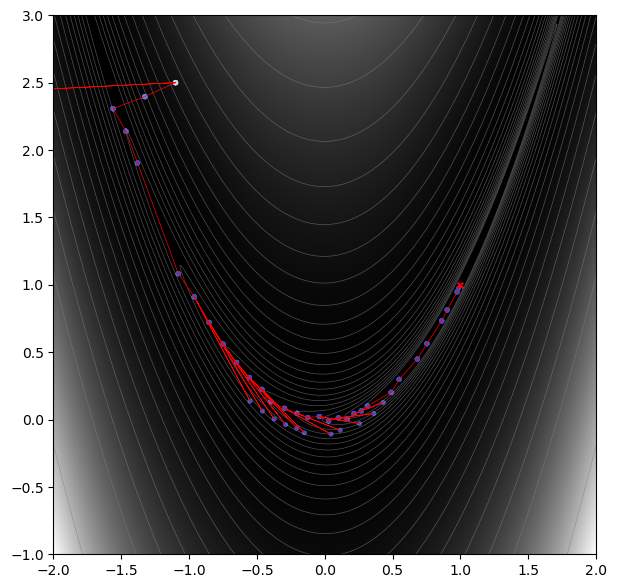

In [ ]:
func = FunctionDescent('rosen')
optimizer = tz.Optimizer(
    func.parameters(),
    tz.m.NewtonCGSteihaug(),
)
func.run(optimizer, max_steps=30)
func.plot(log_contour=True)

### 4.3 Higher order Newton
The $n$-th order version of Newton's method forms and minimizes a polynomial model of the objective function given by it's $n$-th order Taylor polynomial approximation.

When the second order model is defined by the gradient and the hessian matrix, the higher order model also incorporates tensors of higher order derivatives. For example hessian is a 2D tensor (a matrix), 3rd order derivatives are given by a tensor of 3 dimensions, etc. Therefore $n$-th order Newton requires $N^n$ storage to store the tensor of $n$-th order derivatives, where $N$ is number of variables.

Consider that $i,j,k$-th element of the 3rd-order tensor equals 10, that means that there is a term $\frac{10x_ix_jx_k}{3!}$ in the third order model. The 3 factorial comes from taylor series formula, for 4th order it becomes 4 factorial etc. Specifically derivative of $x^3$ is $3x^2$, second derivative is $6x$, which is $3!x$. 

There are actually six such terms given by permutations of $i,j,k$ that are equal to each other - $10x_ix_jx_k$, $10x_ix_kx_j$, $10x_jx_ix_k$, $10x_jx_kx_i$, $10x_kx_ix_j$, $10x_kx_jx_i$. Because there are six terms, and they are divided by six, the sixes actually cancel out.

Unfortunately the higher order model doesn't have a simple solution to find the minima, such as $H^{-1}g$ in Newton, so it itself has to be minimized by an iterative method which is in fact usually 2nd order Newton with a trust region, and isn't even guaranteed to converge. The higher order polynomial has known gradient and hessian that can be computed without relying on autograd. So, there may be very specific cases where Higher order Newton is useful, but in most cases it does not appear to be practical, as both computing higher order derivatives and minimizing the model are very expensive.

As an example, consider rosenbrock function which is is a 4th order polynomial function. Therefore by calculating derivatives up to 4th order, we obtain a perfect model of rosenbrock and by minimizing it, we minimize rosenbrock in a single iteraion.

finished in a very short time, reached loss = 1.68e-10                                      


<Axes: >

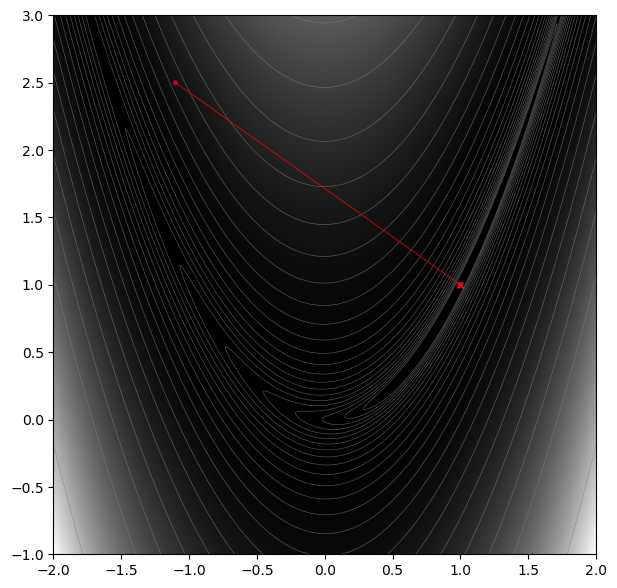

In [ ]:
func = FunctionDescent('rosen')
optimizer = tz.Optimizer(
    func.parameters(),
    tz.m.experimental.HigherOrderNewton(trust_method=None),
)

func.run(optimizer, max_steps=2)
func.plot(log_contour=True)

### 4.4 NewtonNewton
This is an experimental higher order method that I have devised. Here is how it works:

1. Calculate newton step by solving $Hx=g$ and obtaining $x$.

2. Calculate jacobian of $x$ w.r.t. parameters and call it $H_2$. The procedure of calculating $H_2$ is the same as the procedure of calculating the hessian $H$ as jacobian of $g$ w.r.t. parameters.

3. Solve $H_2 x_2 = x$ for $x_2$. Now $x_2$ is the NewtonNewton direction.

4. Optionally, repeat to get $x_3$ - a NewtonNewtonNewton direction, etc.

NewtonNewton appears to only be suitable for convex functions under ~40 variables where it sometimes outperforms Newton in terms of time needed to converge, but not always.

finished in 0.0s., reached loss = 6.64e-06                                      
finished in 0.0s., reached loss = 7.34e-11                                      


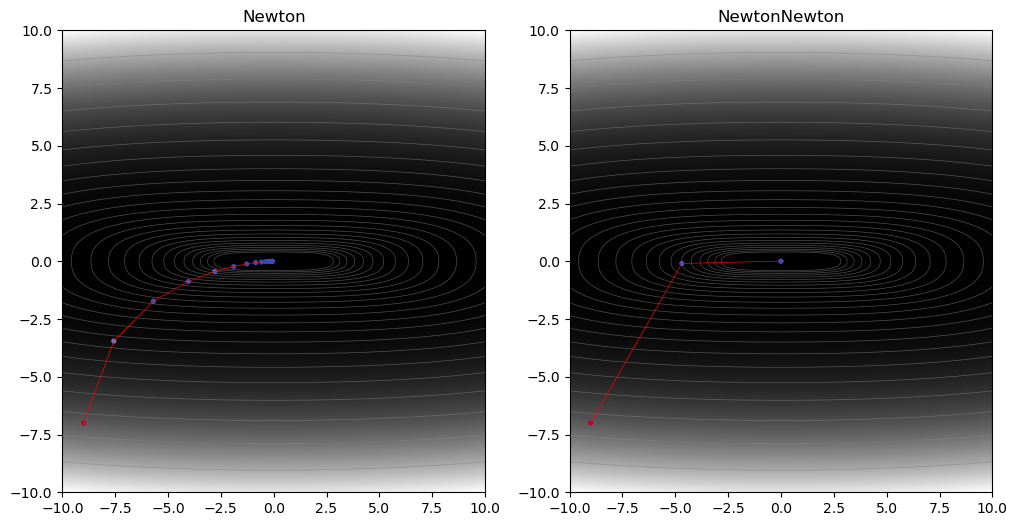

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(12,6))
ax = np.ravel(ax)

# f(x, y) = x^4 + 10|y^3| + 10(xy)^2
f = lambda x, y: x**4 + ((10*y)**3).abs() + 10*(x*y)**2

# ---------------------------------- newton ---------------------------------- #
func = FunctionDescent(f, x0=(-9,-7), domain=(-10,10,-10,10))
optimizer = tz.Optimizer(
    func.parameters(),
    tz.m.Newton(),
)
func.run(optimizer, max_steps=15)
func.plot(log_contour=True, ax=ax[0])
ax[0].set_title("Newton")

# ------------------------------- newton-newton ------------------------------ #
func = FunctionDescent(f, x0=(-9,-7), domain=(-10,10,-10,10))
optimizer = tz.Optimizer(
    func.parameters(),
    tz.m.experimental.NewtonNewton(),
)
func.run(optimizer, max_steps=4)
func.plot(log_contour=True, ax=ax[1])
ax[1].set_title("NewtonNewton")

plt.show()